In [1]:
import sys
import time

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt

In [2]:
from rg_dataset import LRG, UNLRG, UNLRG_C

In [3]:
lrg_data_set = LRG(use_kittler=True)
# unlrg_data_set = UNLRG_C(use_kittler=True)

LRG:	1442/1442


In [4]:
data_loader_lrg   = DataLoader(lrg_data_set, batch_size=128, shuffle=False)
# data_loader_unlrg = DataLoader(unlrg_data_set, batch_size=128, shuffle=False)

sample = iter(data_loader_lrg).next()

In [5]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



def convT3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 Transpose convolution with padding"""
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, output_padding=(stride-1), groups=groups, bias=False, dilation=dilation)

def convT1x1(in_planes, out_planes, stride=1):
    """1x1 Transpose convolution"""
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                              padding=0, output_padding=1, bias=False)

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, conv1=conv1x1, conv3=conv3x3, v=False):
        super(BasicBlock, self).__init__()
        self.v = v
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        if(self.v > 1): out = self.relu(out)

        return out

In [7]:
blocks = []
n_filters=[1, 64, 128, 256, 512, 1024]
for i in range(1, len(n_filters)):
    f_i, f_o = n_filters[i - 1], n_filters[i]
    downsample = nn.Sequential(conv1x1(f_i,  f_o, 2), nn.BatchNorm2d(f_o))
    blocks.append(BasicBlock(f_i, f_o, stride=2, downsample=downsample))

for i in range(len(n_filters)-1, 0, -1):
    f_i, f_o = n_filters[i], n_filters[i-1]
    downsample = nn.Sequential(convT1x1(f_i, f_o, 2), nn.BatchNorm2d(f_o))
    blocks.append(BasicBlock(f_i, f_o, stride=2, downsample=downsample, conv1=convT1x1, conv3=convT3x3, v=f_o==1))

bl = nn.Sequential(*blocks)
# vae(sample[0].cuda())[0].shape

In [8]:
class ResNET_VAE(nn.Module):
    def __init__(self, lt_dim=4):
        super(ResNET_VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
        encoder_layers = []
        for i in range(1, len(n_filters)):
            f_i, f_o = self.k[i - 1], self.k[i]
            downsample = nn.Sequential(conv1x1(f_i,  f_o, 2), nn.BatchNorm2d(f_o))
            encoder_layers.append(BasicBlock(f_i, f_o, stride=2, downsample=downsample))
            
        decoder_layers = []
        for i in range(len(n_filters)-1, 0, -1):
            f_i, f_o = self.k[i], self.k[i-1]
            downsample = nn.Sequential(convT1x1(f_i, f_o, 2), nn.BatchNorm2d(f_o))
            decoder_layers.append(BasicBlock(f_i, f_o, stride=2, downsample=downsample, conv1=convT1x1, conv3=convT3x3, v=True))
            
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [9]:
class B_VAE_Loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        #self.recon_ls = nn.BCEWithLogitsLoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [15]:
device = 'cuda'
epochs = 1000
vae = ResNET_VAE().to(device)
beta_vae_loss = B_VAE_Loss(gamma=15, max_capacity=20, epochs=epochs)
optimizer = Adam(vae.parameters(), lr=0.001, weight_decay=1e-5)

In [16]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        #########       FRI vs FRII         #########
        o = torch.sigmoid(output[1][:, 1])[target > 1]
        c = target[target > 1]
        o = o[c < 4]
        c = c[c < 4]
        c = Variable( (c == 3).float().to(device), requires_grad=False)
        fr_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        #########   Regular vs Irregular   #########
#         o = torch.sigmoid(output[1][:, 2])[target > 1]
#         c = target[target > 1]
# #         o = o[c < 4]
#         c = c < 4
#         c = Variable( c.float().to(device), requires_grad=False)
#         reg_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss + 10 * (ext_loss + fr_loss)# + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:10.4f}\tR_Loss: {:10.4f}\tCapacity: {:10.4f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [17]:
epochs = 200
beta_vae_loss = B_VAE_Loss(gamma=10, max_capacity=20, epochs=epochs)
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s = train_step(vae, 'cuda', data_loader_lrg, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))
    beta_vae_loss.update()

Train Epoch: 1 [9408/14420 (99%)]	Loss:  2424.0596	R_Loss:  2407.9358	Capacity:     0.0000	Time 11.27s
Train Epoch: 2 [9408/14420 (99%)]	Loss:  2076.2949	R_Loss:  2062.1848	Capacity:     0.1000	Time 11.30s
Train Epoch: 3 [9408/14420 (99%)]	Loss:  1795.5531	R_Loss:  1781.5813	Capacity:     0.2000	Time 11.01s
Train Epoch: 4 [9408/14420 (99%)]	Loss:  1565.7449	R_Loss:  1550.7743	Capacity:     0.3000	Time 11.11s
Train Epoch: 5 [9408/14420 (99%)]	Loss:  1364.8313	R_Loss:  1350.0662	Capacity:     0.4000	Time 11.27s
Train Epoch: 6 [9408/14420 (99%)]	Loss:  1208.6816	R_Loss:  1197.1093	Capacity:     0.5000	Time 11.15s
Train Epoch: 7 [9408/14420 (99%)]	Loss:  1077.1421	R_Loss:  1065.8583	Capacity:     0.6000	Time 11.11s
Train Epoch: 8 [9408/14420 (99%)]	Loss:   973.3613	R_Loss:   962.1029	Capacity:     0.7000	Time 11.09s
Train Epoch: 9 [9408/14420 (99%)]	Loss:   874.6936	R_Loss:   864.3838	Capacity:     0.8000	Time 11.05s
Train Epoch: 10 [9408/14420 (99%)]	Loss:   800.5966	R_Loss:   786.9543	Ca

Train Epoch: 79 [9408/14420 (99%)]	Loss:   214.5941	R_Loss:   205.6548	Capacity:     7.8000	Time 11.21s
Train Epoch: 80 [9408/14420 (99%)]	Loss:   216.3747	R_Loss:   204.8930	Capacity:     7.9000	Time 11.04s
Train Epoch: 81 [9408/14420 (99%)]	Loss:   215.7609	R_Loss:   207.8566	Capacity:     8.0000	Time 11.00s
Train Epoch: 82 [9408/14420 (99%)]	Loss:   219.4124	R_Loss:   208.8774	Capacity:     8.1000	Time 11.06s
Train Epoch: 83 [9408/14420 (99%)]	Loss:   210.9140	R_Loss:   197.8746	Capacity:     8.2000	Time 11.05s
Train Epoch: 84 [9408/14420 (99%)]	Loss:   207.6063	R_Loss:   195.5728	Capacity:     8.3000	Time 11.01s
Train Epoch: 85 [9408/14420 (99%)]	Loss:   206.4864	R_Loss:   197.3606	Capacity:     8.4000	Time 11.08s
Train Epoch: 86 [9408/14420 (99%)]	Loss:   206.5762	R_Loss:   197.8953	Capacity:     8.5000	Time 11.13s
Train Epoch: 87 [9408/14420 (99%)]	Loss:   203.9295	R_Loss:   192.0114	Capacity:     8.6000	Time 11.14s
Train Epoch: 88 [9408/14420 (99%)]	Loss:   208.0602	R_Loss:   19

Train Epoch: 157 [9408/14420 (99%)]	Loss:   189.1818	R_Loss:   182.7567	Capacity:    15.6000	Time 11.14s
Train Epoch: 158 [9408/14420 (99%)]	Loss:   195.3441	R_Loss:   183.9838	Capacity:    15.7000	Time 11.13s
Train Epoch: 159 [9408/14420 (99%)]	Loss:   191.0005	R_Loss:   181.5909	Capacity:    15.8000	Time 11.09s
Train Epoch: 160 [9408/14420 (99%)]	Loss:   190.6259	R_Loss:   182.0008	Capacity:    15.9000	Time 11.10s
Train Epoch: 161 [9408/14420 (99%)]	Loss:   184.8245	R_Loss:   179.8569	Capacity:    16.0000	Time 11.13s
Train Epoch: 162 [9408/14420 (99%)]	Loss:   196.4149	R_Loss:   186.7043	Capacity:    16.1000	Time 11.07s
Train Epoch: 163 [9408/14420 (99%)]	Loss:   187.6300	R_Loss:   177.3373	Capacity:    16.2000	Time 11.10s
Train Epoch: 164 [9408/14420 (99%)]	Loss:   188.5752	R_Loss:   182.8719	Capacity:    16.3000	Time 11.12s
Train Epoch: 165 [9408/14420 (99%)]	Loss:   187.0452	R_Loss:   181.1984	Capacity:    16.4000	Time 11.15s
Train Epoch: 166 [9408/14420 (99%)]	Loss:   189.3585	R_

In [18]:
# eps = 50
# beta_vae_loss = B_VAE_Loss(gamma=10, max_capacity=20, epochs=eps)
# for epoch in range(1, eps+1):
#     #UN-LRG
#     start = time.time()
#     s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
#     t = time.time() - start
#     sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))
#     beta_vae_loss.update()

(-0.5, 63.5, 63.5, -0.5)

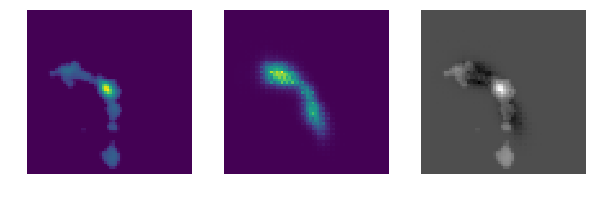

In [19]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')